# Imports


In [2]:
# Common imports
import numpy as np
from pprint import pprint

# to make this notebook's output stable across runs
np.random.seed(42)

#sklearn specific imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV,cross_val_predict
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# scipy
from scipy.stats import loguniform

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure',figsize=(8,6))

# Ignore all warnings (convergence .. ) by sklearn
def warn(*args, ** kwargs):
    pass
import warnings
warnings.warn = warn

# Handwritten Digit Classification

- We are going to use LogisticRegression (Despite it's name) to classify
  (recognize) given digit image. Again, we first apply the model for binary classification and then extend it to multiclass classification.

- Suppose we want to recognize whether the given image is of digit zero or not
  (digits other than zero).Then the problem could be cast as binary
  classification problem.

  - The first step is to create a dataset that contains collection of digit
    images (also called examples,samples) written by humans. Then each image
    should be labelled properly.Daunting task!
  - Fortunately, we have a standard benchmark dataset called MNIST. well, why not make use of it ?. Let us import the dataset first ...


In [3]:
from sklearn.datasets import fetch_openml

X_pd, y_pd = fetch_openml(
    "mnist_784", version=1, return_X_y=True
)  # it returns Data and label as a panda dataframe

The data matrix X and the respective label vector y need to be converted to numpy array by calling a to_numpy method.


In [4]:
X = X_pd.to_numpy()
y = y_pd.to_numpy()

# Pre-Processing

- Unlike perceptron, where scaling the range is optional (but recommended), sigmoid requires scaling the feature range between 0 to 1.

- Contemplate the consequences if we don't apply the scaling operation on the input datapoints.

- Note: Do not apply mean centering as it removes zeros from the data, however, zeros should be zeros in the dataset

- Sine we are using only one preprocessing step, using pipeline may not be required.


In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [6]:
print("Mean of the features:", np.mean(X))
print("Standard Deviation: ", np.std(X))
print("Minimum value: ", np.min(X))
print("Maximum value: ", np.max(X))

Mean of the features: 0.13092720382627604
Standard Deviation:  0.3084510570135976
Minimum value:  0.0
Maximum value:  1.0


In [7]:
target_names = np.unique(y)
print("Number of samples: {0}, type: {1}".format(X.shape[0], X.dtype))
print("Number of features: {0}".format(X.shape[1]))
print("Number of classes: {0}, type:{1}".format(len(target_names), y.dtype))
print("Labels: {0}".format(target_names))

Number of samples: 70000, type: float64
Number of features: 784
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


# Data Visualization

- This section is repeated for convenience.(Had we applied mean centering,there will be a difference in the appearence of images).

- Let us pick a few images (the images are already shuffled in the dataset) and
  display them with their respective labels. As said above, the images are
  stacked as row vector of size 1 x 784 and therefore must be reshaped to matrix
  of size 28 x 28 in order to display them properly.


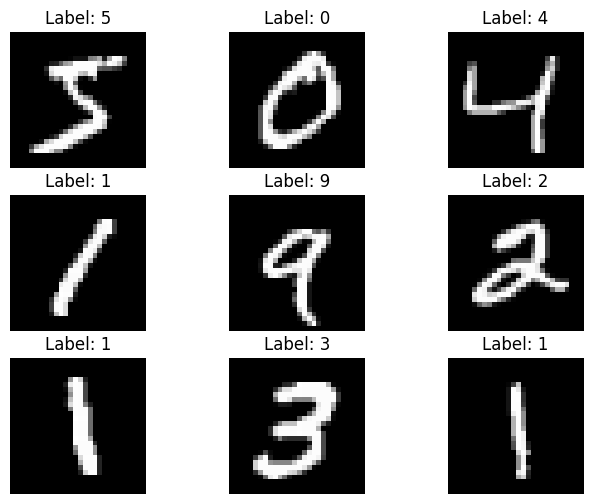

In [8]:
num_images = 9  # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8, 6))
idx_offset = 0  # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i * (factor)
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap="gray")
        ax[i, j].set_title("Label: {0}".format(str(y[index + j])))
        ax[i, j].set_axis_off()

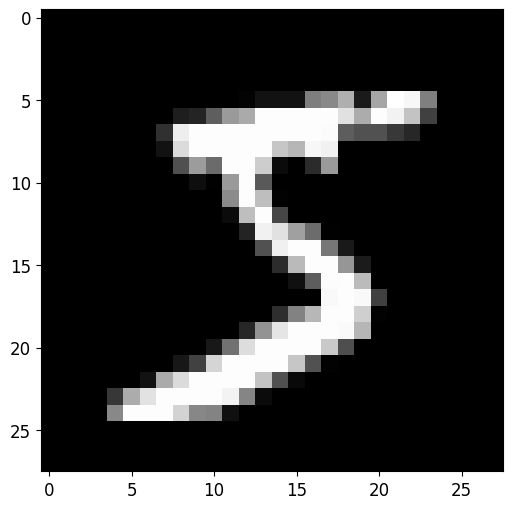

In [9]:
plt.figure(figsize=(6, 6))
plt.imshow(X[0].reshape(28, 28), cmap="gray")
plt.show()

# Data Splitting

- Now, we know details such as number of samples, size of each sample, number of
  features (784), number of classes (targets) about the dataset.

- So let us spilt the total number of samples into train and test set in the
  following ratio: 60000/10000 (that is, 60000 samples in the training set and
  10000 samples in the testing set).

- Since the samples in the data set are already randomly shuffled, we need not to shuffle it again.


In [10]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before procedding further, we need to check whether the dataset is balanced or imbalanced. We can do it py plotting the distribution of
samples in each classes.


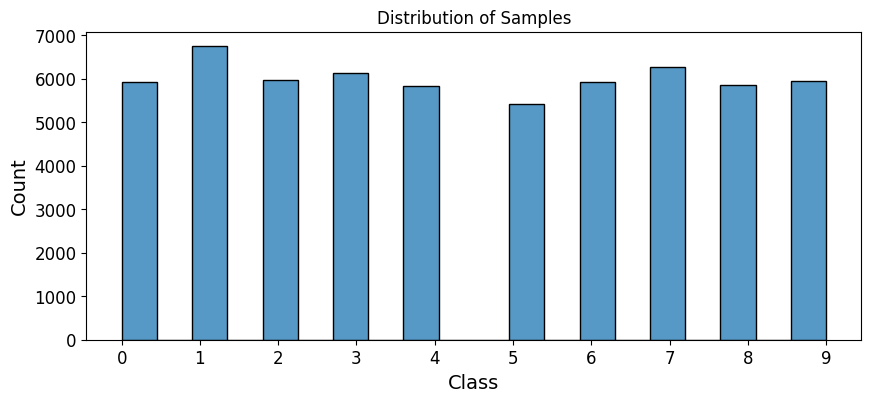

In [11]:
plt.figure(figsize=(10, 4))
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel("Class")
plt.title("Distribution of Samples")
plt.show()

# Binary Classification : 0-Detector

- Let us start with a simple classification problem, that is, binary classification.

- Since the original label vector contains 10 classes, we need to modfiy the
  number of classes to 2.Therefore, the label '0' will be changed to '1' and all
  other labels (1-9) will be changed to '0'. (Note: for perceptron we set the
  negative labels to -1)


In [12]:
# intialize new variable names with all -1
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train == "0")  # remember original labels are of type str not int
# use those indices to modify y_train_0&y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == "0")
y_test_0[indx_0] = 1

# Sanity check

- Let's display the elements of y_train and y_train_o to verify whether the
  labels are properly modified. of course, we can't verify all the 60000 labels by inspection (unless we have a plenty of time or man power)


In [13]:
print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[0. 1. 0. ... 0. 0. 0.]


In [14]:
print(np.where(y_train == "0"))
print(np.where(y_train_0 == 1))

(array([    1,    21,    34, ..., 59952, 59972, 59987], dtype=int64),)
(array([    1,    21,    34, ..., 59952, 59972, 59987], dtype=int64),)


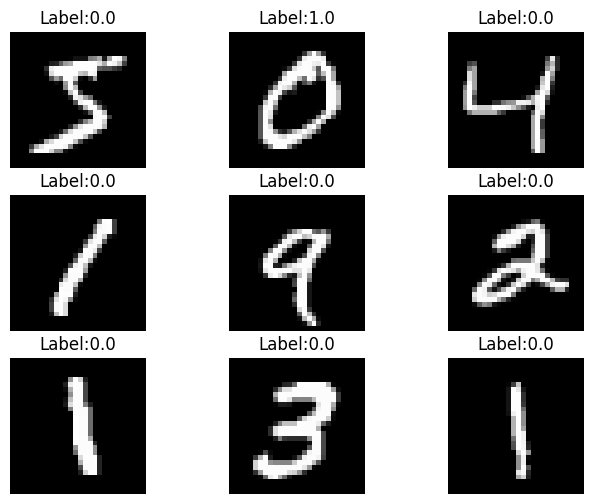

In [15]:
num_images = 9  # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8, 6))
idx_offset = 0  # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i * (factor)
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap="gray")
        ax[i, j].set_title("Label:{0}".format(str(y_train_0[index + j])))
        ax[i, j].set_axis_off()

# Baseline Models

1. Count number of samples per class.
2. The model always outputs the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.


In [16]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == 0)[0])
print(num_pos, num_neg)

5923 54077


In [17]:
base_clf = DummyClassifier(strategy="most_frequent")  # there are other approaches too
base_clf.fit(x_train, y_train_0)
print(base_clf.score(x_train, y_train_0))

0.9012833333333333


# LogisticRegression model

- Before using LogisticRegression for Binary classification problem, it will be
  helpful to recall the important concepts (equations) covered in the technique course.


### Training without regularization


In [18]:
bin_sgd_clf = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    max_iter=1,
    warm_start=True,
    eta0=0.01,
    alpha=0,
    learning_rate="constant",
    random_state=1729,
)

Loss = []
iterations = 100
for i in range(iterations):
    bin_sgd_clf.fit(x_train, y_train_0)
    y_pred = bin_sgd_clf.predict_proba(x_train)
    Loss.append(log_loss(y_train_0, y_pred))

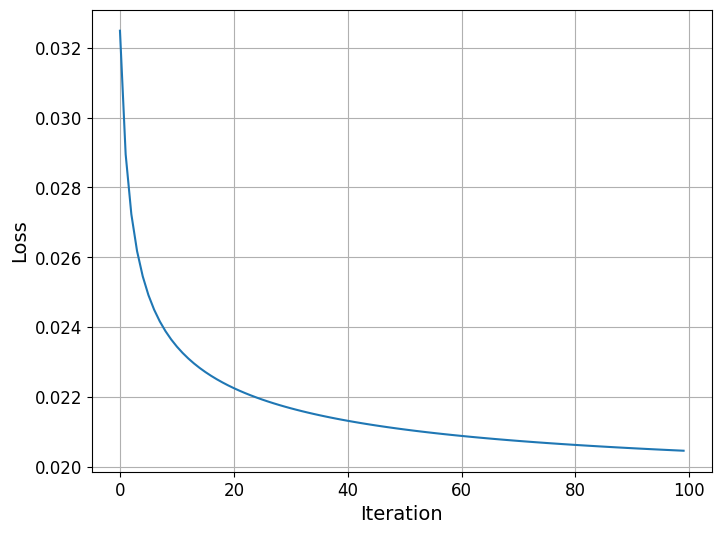

In [19]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration' )
plt.ylabel ('Loss')
plt.show()

In [20]:
print('Training accuracy: %.2f'%bin_sgd_clf.score(x_train,y_train_0))
print('Testing accuracy: %.2f'%bin_sgd_clf.score(x_test,y_test_0))

Training accuracy: 0.99
Testing accuracy: 0.99


In [ ]:
y_hat_train_0 = bin_sgd_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0, values_format='.5g')
plt.show()

In [22]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



In [23]:
estimator = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    max_iter=100,
    warm_start=False,
    eta0=0.01,
    alpha=0,
    learning_rate="constant",
    random_state=1729,
)

In [24]:
cv_bin_clf = cross_validate(
    estimator,
    x_train,
    y_train_0,
    cv=5,
    scoring=["precision", "recall", "f1"],
    return_train_score=True,
    return_estimator=True,
)

pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=1729)],
 'fit_time': array([6.08362913, 3.3322432 , 4.11900377, 3.23209691, 2.75199199]),
 'score_time': array([0.20306921, 0.08688092, 0.15262175, 0.07218337, 0.06133127]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.

- From the above result, we can see that logistic regression is better than the perceptron .!

- However, it is good to check the weight values of all the features and decide whether regularization could be of any help.

In [27]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_
print('Dimention of Weights w: {0}'.format(weights.shape))
print('Bias :{0}'.format(bias))

Dimention of Weights w: (1, 784)
Bias :[-4.89282893]


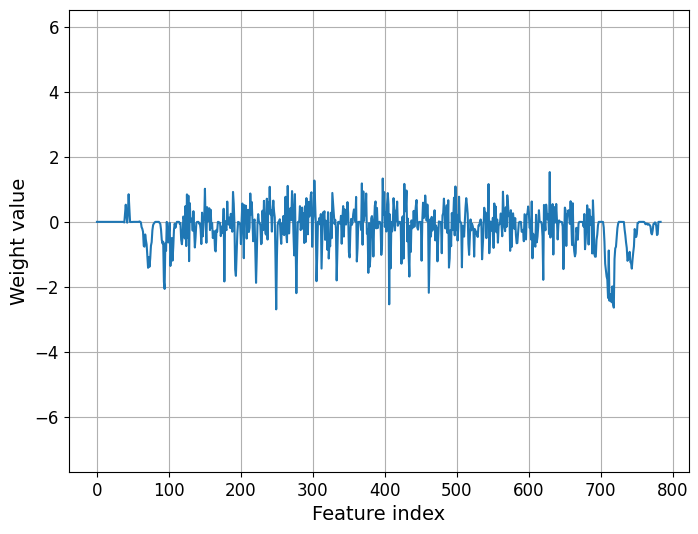

In [28]:
plt.figure()
plt.plot(np.arange(0,784), weights[0,:])
plt.xlabel ('Feature index')
plt.ylabel ('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid()

- It is interesting to observe how many weight values are exactly zero.

- Those features contribute nothing in the classification.

In [29]:
num_zero_w = weights.shape[1]-np.count_nonzero (weights)
print ('Number of weights with value zero: %f'%num_zero_w)

Number of weights with value zero: 67.000000


- From the above plot, it is also obvious that regularization is not required.

# Training with regularization

- However, what happens to the performance of the model if we penalize,out of temptation, the weight values even to a smaller degree.

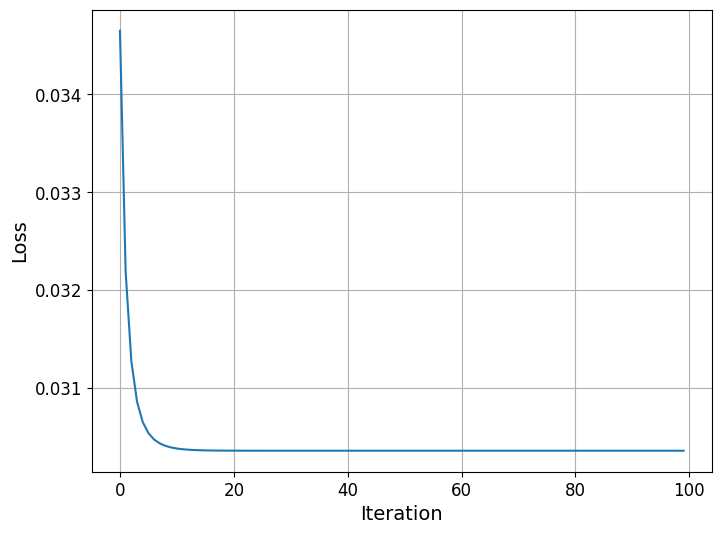

In [30]:
bin_sgd_clf_12 = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=0.001,
    max_iter=1,
    eta0=0.01,
    warm_start=True,
    learning_rate="constant",
    random_state=1729,
)

Loss = []
iterations = 100
for i in range(iterations):
    bin_sgd_clf_12.fit(x_train, y_train_0)
    y_pred = bin_sgd_clf_12.predict_proba(x_train)
    Loss.append(log_loss(y_train_0, y_pred))

plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [31]:
weights = bin_sgd_clf_12.coef_
bias = bin_sgd_clf_12.intercept_
print(bias)

[-4.43002876]


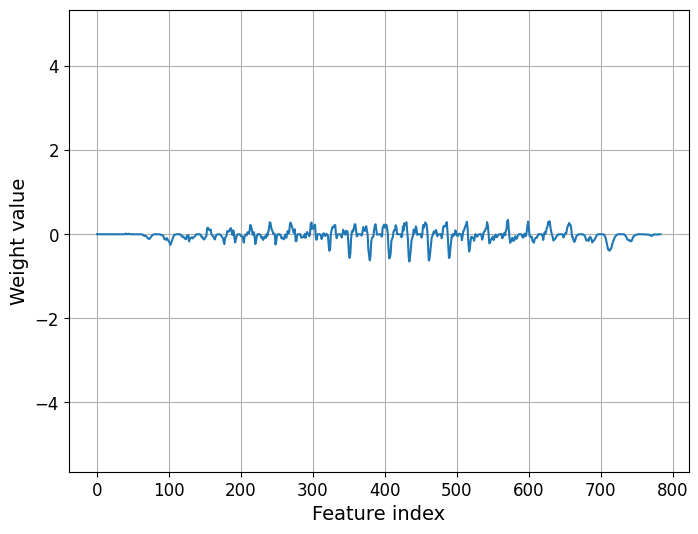

In [32]:
plt.figure()
plt.plot(np.arange(0,784), weights[0,:])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid()

In [33]:
num_zero_w = weights.shape[1]-np.count_nonzero(weights)
print('Number of weights with value zero: %f'%num_zero_w)

Number of weights with value zero: 67.000000


In [34]:
print('Training accuracy %.2f'%bin_sgd_clf_12.score(x_train,y_train_0))
print('Testing accuracy %.2f'%bin_sgd_clf_12.score(x_test,y_test_0))

Training accuracy 0.99
Testing accuracy 0.99


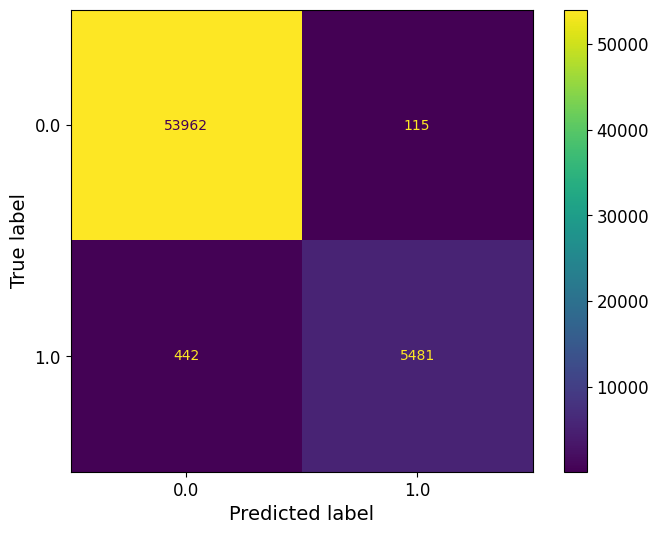

In [35]:
y_hat_train_0 = bin_sgd_clf_12.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0, values_format='.5g')
plt.show()

In [36]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



# Displaying input image

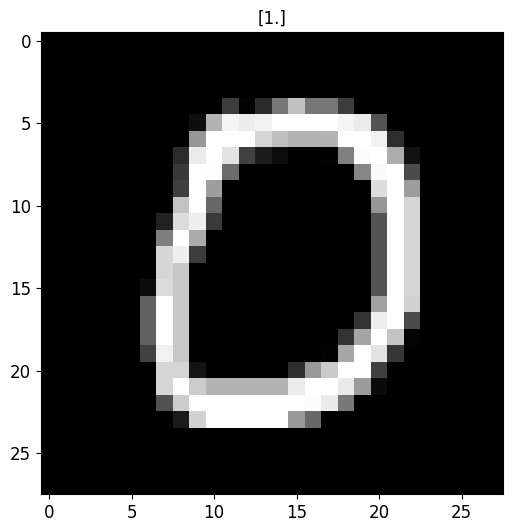

In [37]:
index = 10 # try some other index
plt.imshow(x_test[index,: ].reshape(28, 28) , cmap='gray')
pred = bin_sgd_clf.predict(x_test[index].reshape(1,-1))
plt.title(str(pred))
plt.show()

Let's plot a few images and their respective **predictions** with SGDclassifier without regularization.

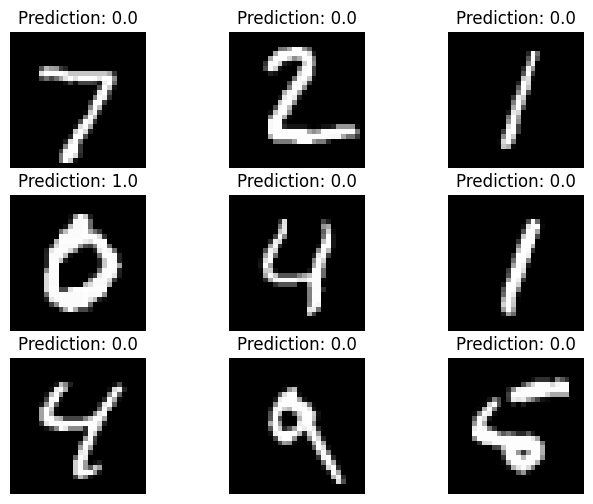

In [38]:
y_hat_test_0 = bin_sgd_clf.predict(x_test)
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images) )
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # display "num_images" starting from idx_offset
for i in range(factor):
    index = idx_offset+i*(factor)
    for j in range(factor):
        ax[i, j].imshow(x_test[index+j].reshape(28, 28) , cmap='gray') # we should not use x_train_with_dummy
        ax[i, j].set_title('Prediction: {0}'.format(str(y_hat_test_0[index+j])))
        ax[i, j].set_axis_off()

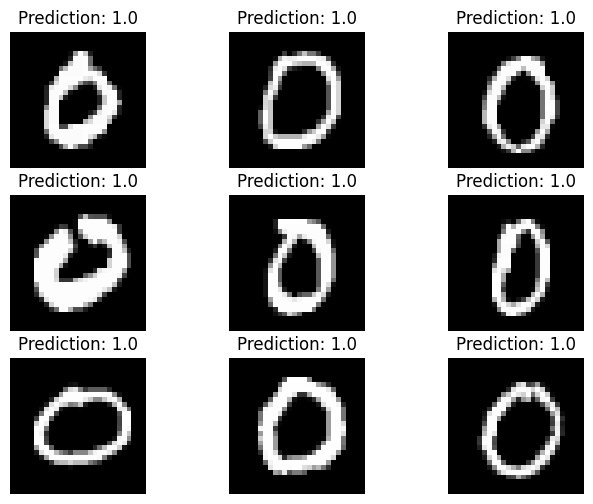

In [39]:
indx_0 =np.where(y_test_0 == 1)

zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0 [0]]
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # display "num_images" starting from idx_offset
for i in range(factor):
    index = idx_offset+i*(factor)
    for j in range(factor):
        ax[i, j].imshow(zeroImgs [index+j].reshape(28,28) , cmap='gray') # we should not use x_train_with_dummy
        ax[i, j].set_title('Prediction: {0}'.format (str (zeroLabls [index+j])))
        ax[i, j].set_axis_off()

# Hyper-parameter tuning

- We have to use cross-validation folds and measure the same metrics across these folds for different values of hyper-parameters.

- Logistic regression uses sgd solver and hence the learning rate and regularization rate are two important hyper-parameters

- For the moment, we skip penalizing the parameters of the model and just search
  for a better learning rate using RandomizedSearchCV() and draw the value from
  the uniform distribution.

In [40]:
lr_grid = loguniform(1e-2,1e-1)

- Note that, `lr_grid` is an object that contains a method called `rvs()` which can be used to get the samples of given size.

- Therefore, we pass this `lr_grid` object to `RandomizedSearchCV()` . Internally, it makes use of this `rvs()` method for sampling.

In [41]:
print(lr_grid.rvs(3,random_state=42))

[0.02368864 0.0892718  0.05395031]


In [42]:
# repeating for convenience
estimator = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    max_iter=1,
    warm_start=True,
    eta0=0.01,
    alpha=0,
    learning_rate="constant",
    random_state=1729,
)

In [43]:
scores = RandomizedSearchCV(
    estimator,
    param_distributions={"eta0": lr_grid},
    cv=5,
    scoring=["precision", "recall", "f1"],
    n_iter=5,
    refit="f1",
)

In [44]:
# It take quite a long time to finish
scores.fit(x_train,y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant',
                                           loss='log_loss', max_iter=1,
                                           random_state=1729, warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001DD3746C0A0>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [45]:
pprint(scores.cv_results_)

{'mean_fit_time': array([3.54565129, 0.97626414, 0.90967302, 0.91109738, 0.96340556]),
 'mean_score_time': array([0.10796809, 0.06537027, 0.10474334, 0.07876139, 0.08286419]),
 'mean_test_f1': array([0.95383975, 0.94148246, 0.94869555, 0.95090017, 0.95474878]),
 'mean_test_precision': array([0.96136672, 0.93597638, 0.94998271, 0.9540212 , 0.96640269]),
 'mean_test_recall': array([0.94682062, 0.94851138, 0.94834146, 0.94850966, 0.94361173]),
 'param_eta0': masked_array(data=[0.023688639503640783, 0.08927180304353628,
                   0.05395030966670229, 0.03968793330444373,
                   0.014322493718230255],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.023688639503640783},
            {'eta0': 0.08927180304353628},
            {'eta0': 0.05395030966670229},
            {'eta0': 0.03968793330444373},
            {'eta0': 0.014322493718230255}],
 'rank_test_f1': array([2, 5, 4, 3, 1]),
 'rank_test

In [46]:
best_bin_clf = scores.best_estimator_

y_hat_train_best_0 = best_bin_clf.predict(x_train)

print(classification_report(y_train_0,y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



# Classification Report

**Precision/Recall Tradeoff**

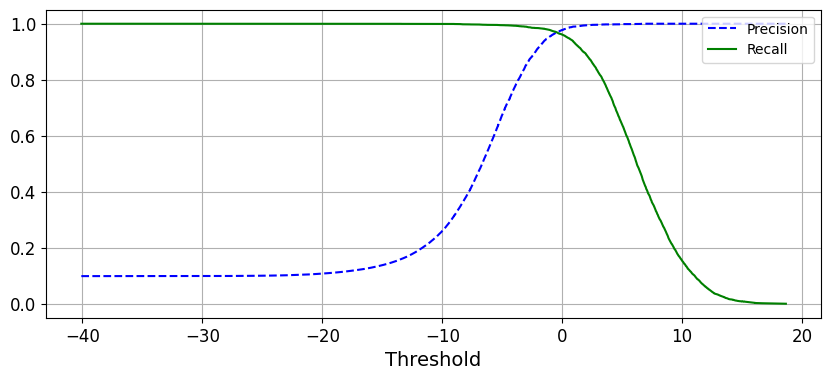

In [47]:
y_scores = bin_sgd_clf.decision_function(x_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(thresholds, precisions [ :- 1], "b--", label="Precision")
plt.plot(thresholds, recalls[ :- 1], "g-", label="Recall")
plt.xlabel ('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

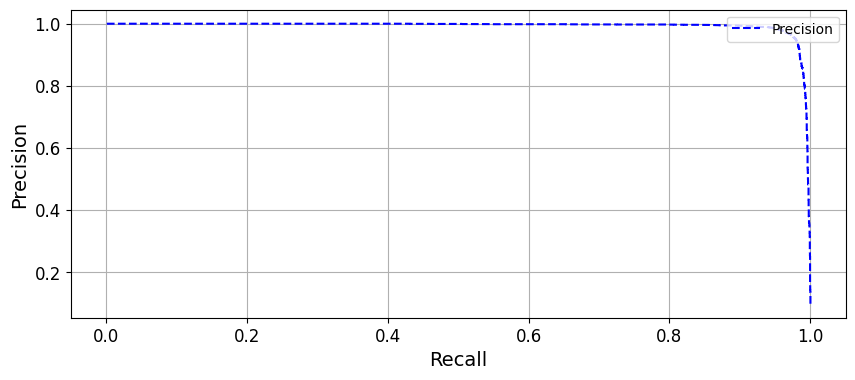

In [48]:
plt.figure(figsize=(10,4))
plt.plot( recalls[ :- 1], precisions[ :- 1],"b--", label="Precision")
plt.ylabel ('Precision')
plt.xlabel ('Recall')
plt.grid(True)
plt.legend(loc='upper right')
plt.show ()

### ROC Curve

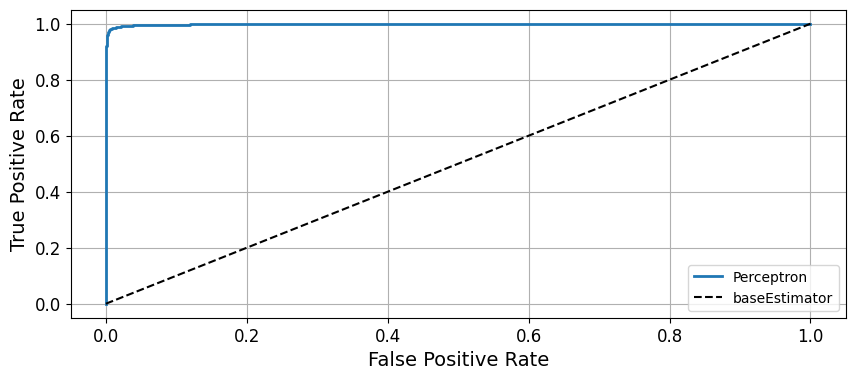

In [49]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2, label='Perceptron')
plt.plot([0, 1], [0, 1], 'k--', label='baseEstimator')
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.grid(True)
plt. legend ()
plt.show()

In [50]:
auc = roc_auc_score(y_train_0,y_scores)
print('AUC: %.3f' % auc)

AUC: 0.998


# Logistic Regression

### Training without regularization

- STEP 1: Instantiate a pipeline object with two stages:
    - The first stage contains MinMaxScaler for scaling the input.
    - The second state contains a LogisticRegression classifier with the regularization rate C=infinity.

- STEP 2: Train the pipeline with feature matrix x_train and label vector y_train_0.

In [51]:
pipe_logit = make_pipeline(
    MinMaxScaler(), LogisticRegression(random_state=1729, solver="lbfgs", C=np.infty)
)

pipe_logit.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

# Hyperparameter search
- In this section, we will search for the best value for parameter c under certain scoring function.

### GridSearchCV

In the previous cell, we trained LogisticRegression classifier with C=infinity.
You may wonder if that's the best value for c and if it is not the best value,
how do we search for it? Now we will demonstrate how to search for the best
parameter value for regularization rate c, as an illustration, using
GridSearchCV.

> Note that you can also use RandomizedSearchcv for this purpose.

In order to use GridSearchcv, we first define a set of values that we want to
try out for c. The best value of c will be found from this set. We define the
pipleline object exactly like before with one exception: we have set parameter
value C to 1 in LogisticRegression estimator. You can set it to any value as the best value would be searched with grid search.

The additional step here is to instatiate a GridSearchcv object with a pipeline
estimator, parameter grid specification and f1 as a scoring function.

> Note that you can use other scoring functions like precision, recall, however
> the value of c is found such that the given scoring function is optimized.

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

grid_Cs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

scaler = MinMaxScaler()
logreg = LogisticRegression(C=1.0, random_state=1729)

pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logreg)])

pipe_logit_cv = GridSearchCV(pipe, param_grid={"logistic__C": grid_Cs}, scoring="f1")
pipe_logit_cv.fit(x_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

In [54]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

In [55]:
pipe_logit_cv.best_score_

0.9582781080330685

In [56]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

### With `LogisticRegressionCV`

- Instead of using GridSearchCV for finding the best value for parameter c, we can use LogisticRegressionCV for performing the same job.

- STEP 1: Here we make use of LogisticRegressionCV estimator with number of cross validation folds cv=5 and scoring scheme
scoring='f1' in the pipeline object.

- STEP 2: In the second step, we train the pipeline object as before.

In [57]:
from sklearn.linear_model import LogisticRegressionCV

estimator = LogisticRegressionCV(cv=5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

## Performance evaluation

### Precision, recall and f1-score
Let's evaluate performance of these three different logistic regression classifiers for detecting digit 0 from the image.

- Logistic regression without regularization.

- Best logistic regression classifier found through GridSearchCV.

- Best classifier found through LogisticRegressionCV.

> Note that GridSearchcv and LogisticRegressioncv by default refit the classifier for the best hyperparameter values.

In [59]:
lr_y_hat_0 = pipe_logit.predict(x_test)
lr_gs_y_hat_0 =pipe_logit_cv.best_estimator_.predict(x_test)
lr_cv_y_hat_0 = logit_cv.predict(x_test)

In [60]:
precision_lr= precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

In [61]:
print (f"LogReg: precision={precision_lr}, recall={recall_lr}")
print (f"GridSearch: precision={precision_lr_gs}, recall={recall_lr_gs}")
print (f"LogRegCV: precision={precision_lr_cv}, recall={recall_lr_cv}")

LogReg: precision=0.9544994944388271, recall=0.963265306122449
GridSearch: precision=0.9555555555555556, recall=0.9653061224489796
LogRegCV: precision=0.9526686807653575, recall=0.9653061224489796


Note that all three classifiers have roughly the same performance as measured with precision and recall.

- The LogisticRegression classifier obtained through GridSearchcv has the highest precision - marginally higher than the other two
classifiers.

- The LogisticRegression classifier obtained through LogisticRegressioncv has the highest recall - marginally higher than the other
two classifiers.

In [62]:
y_scores_lr = pipe_logit.decision_function(x_test)
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(
y_test_0, y_scores_lr)

y_scores_lr_gs = pipe_logit_cv.decision_function(x_test)
precisions_lr_gs, recalls_lr_gs, thresholds_lr_gs = precision_recall_curve(
y_test_0, y_scores_lr_gs)

y_scores_lr_cv = logit_cv.decision_function(x_test)
precisions_lr_cv, recalls_lr_cv, thresholds_lr_cv = precision_recall_curve(
y_test_0, y_scores_lr_cv)

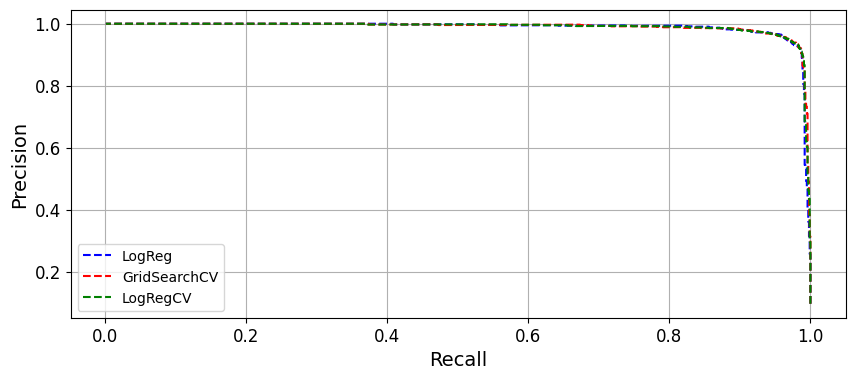

In [63]:
plt.figure(figsize=(10,4))
plt.plot(recalls_lr[ :- 1], precisions_lr[ :- 1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[ :- 1], precisions_lr_gs[ :- 1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[ :- 1], precisions_lr_cv[ :- 1], 'g--', label='LogRegCV')

plt.ylabel ('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.legend(loc='lower left')
plt.show ()

Note that the PR curves for all three classifiers overlap significantly.
Let's calculate area under the PR curve:

In [64]:
from sklearn.metrics import auc

auc_lr = auc(recalls_lr[ :- 1], precisions_lr[ :- 1])
auc_lr_gs = auc(recalls_lr_gs[ :- 1], precisions_lr_gs[ :- 1])
auc_lr_cv = auc(recalls_lr_cv[ :- 1], precisions_lr_cv[ :- 1])

print ("AUC-PR for logistic regression:", auc_lr)
print ("AUC-PR for grid search:", auc_lr_gs)
print ("AUC-PR for logistic regression CV:", auc_lr_cv)

AUC-PR for logistic regression: 0.9872513414335629
AUC-PR for grid search: 0.9884540467590757
AUC-PR for logistic regression CV: 0.9882682337599971


Observe that the AUC for all three classifier is roughly the same with LogisticRegression classifier obtained through cross validation and
grid search have slightly higher AUC under PR curve.

### Confusion matrix
- We show a confusion matrix for test set with logistic regression classifier:

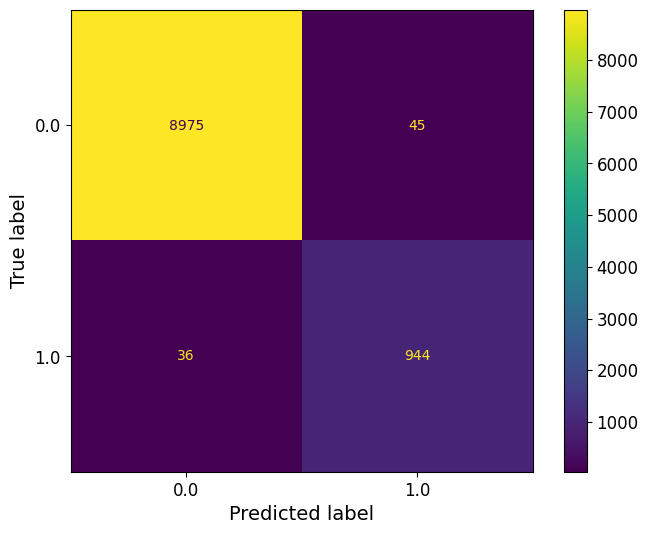

In [65]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,lr_y_hat_0,values_format='.5g')

plt. show()

Confusion matrix for test set with logistic regression classifier obtained through grid search:

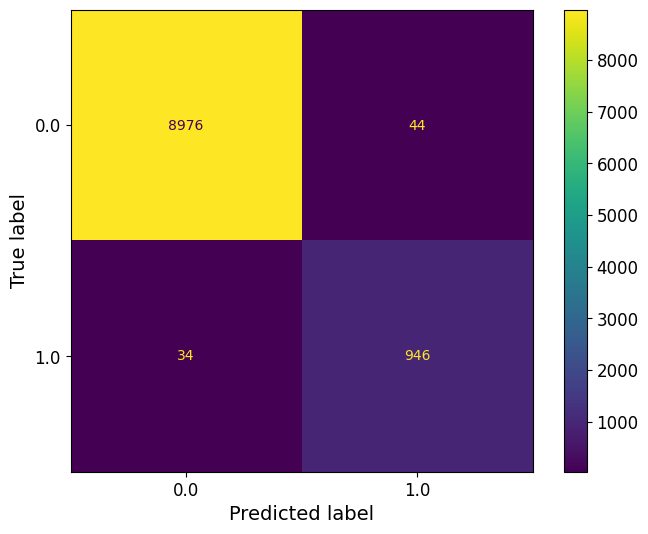

In [66]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,lr_gs_y_hat_0,values_format='.5g')
plt.show()

# Ridge Classifier

- Ridge classifier cast the problem as least-square classification and finds the
  optimal weight using some matrix decomposition technique such as SVD.

- To train the ridge classifier, the labels should be y E {+1, -1}.

- The classifier also by default implements L2 regularization. However, we first implement it without regularization by setting alpha=0

In [67]:
# intialize new variable names with all -1
y_train_0= -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0=np.where(y_train == '0')

# use those indices to modify y_train_0&y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

In [69]:
estimator = RidgeClassifier(alpha=0)
pipe_ridge = make_pipeline(MinMaxScaler(),estimator)
pipe_ridge.fit(x_train,y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))])

### Performance

In [70]:
y_hat_test_0 = pipe_ridge.predict(x_test)
print(classification_report(y_test_0,y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.95      0.89      0.92       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



### Cross Validation

In [72]:
cv_bin_ridge_clf = cross_validate(
    pipe_ridge,
    x_train,
    y_train_0,
    cv=5,
    scoring=["precision", "recall", "f1"],
    return_train_score=True,
    return_estimator=True,
)
pprint(cv_bin_ridge_clf)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))])],
 'fit_time': array([12.92375422, 11.65178466, 10.22069359,  9.82290959, 10.50017715]),
 'score_time': array([0.24131942, 0.25755024, 0.13330388, 0.55002499, 0.12997794]),
 'test_f1': array([0.91415929, 0.90062112, 0.92035398, 0.90354419, 0.90780768]),
 'test_precision': array([0.96003717, 0.94859813, 0.96744186, 0.96455939, 0.95101664]),
 'test_re

In [73]:
best_estimator_id = np.argmax(cv_bin_ridge_clf['train_f1'])
best_estimator_id

2

In [74]:
best_estimator = cv_bin_ridge_clf['estimator' ] [best_estimator_id]

In [75]:
y_hat_test_0 = best_estimator.predict(x_test)
print(classification_report(y_test_0,y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.96      0.89      0.92       980

    accuracy                           0.99     10000
   macro avg       0.97      0.94      0.96     10000
weighted avg       0.98      0.99      0.98     10000



In [78]:
pipe_sgd = make_pipeline(MinMaxScaler(), SGDClassifier(loss="log_loss"))
pipe_sgd.fit(x_train, y_train_0)

pipe_sgd_l2 = make_pipeline(MinMaxScaler(), SGDClassifier(loss="log_loss", penalty="l2"))
pipe_sgd_l2.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('sgdclassifier', SGDClassifier(loss='log_loss'))])

## Further exploration
Let's see what these classifiers leant about the digit 0

<Figure size 400x400 with 0 Axes>

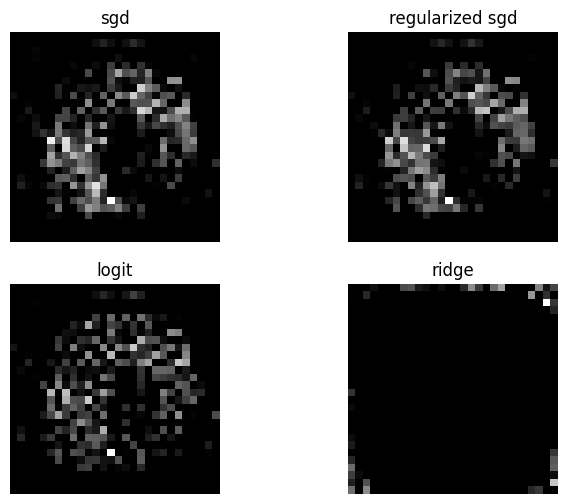

In [79]:
models = (pipe_sgd, pipe_sgd_l2, pipe_logit, pipe_ridge)
titles = ('sgd', 'regularized sgd', 'logit', 'ridge')
plt.figure(figsize=(4, 4))
plt.subplots(2, 2)
for i in range(0, 4):
    w = models[i][1].coef_
    w_matrix = w.reshape(28, 28)
    w_matrix[w_matrix < 0]=0 #just set the value less than zero to zero
    plt.subplot(2, 2, i+1)
    plt.imshow(w_matrix, cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
    plt.grid(False)
fig.show ()

# Multiclass Classifier (OneVsAll)

### SGD with LogitMulticlass

In [82]:
estimator = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    max_iter=1,
    warm_start=True,
    eta0=0.01,
    alpha=0,
    learning_rate="constant",
    random_state=1729,
)
pipe_sgd_ovr = make_pipeline(MinMaxScaler(), estimator)

In [83]:
Loss=[]
iterations= 100
for i in range(iterations):
    pipe_sgd_ovr.fit(x_train,y_train)
    y_pred = pipe_sgd_ovr.predict_proba(x_train)
    Loss.append(log_loss(y_train, y_pred) )

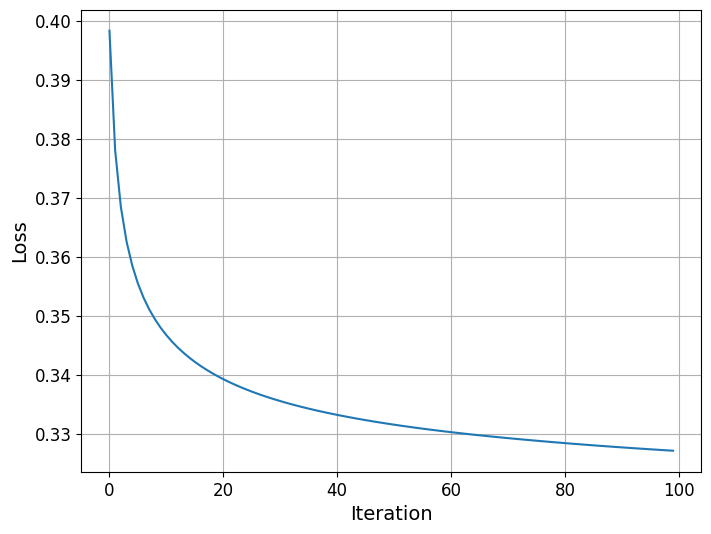

In [84]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel ('Iteration' )
plt.ylabel ('Loss')
plt. show ()

What actually happened behind the screen is that the library automatically created 10 binary classifiers and trained them !. During the inference
time, the input will be passed through all the 10 classifiers and the highest score among the ouputs will be considered as the predicted class.To
see it in action, let us execute the following lines of code

In [85]:
pipe_sgd_ovr[1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=1, random_state=1729, warm_start=True)

In [86]:
pipe_sgd_ovr[1].coef_.shape

(10, 784)

So it is a matrix of size 10 x 784. A row represents the weights of a single binary classifier.

In [87]:
y_hat = pipe_sgd_ovr.predict(x_test); y_hat[:5]

array(['7', '2', '1', '0', '4'], dtype='<U1')

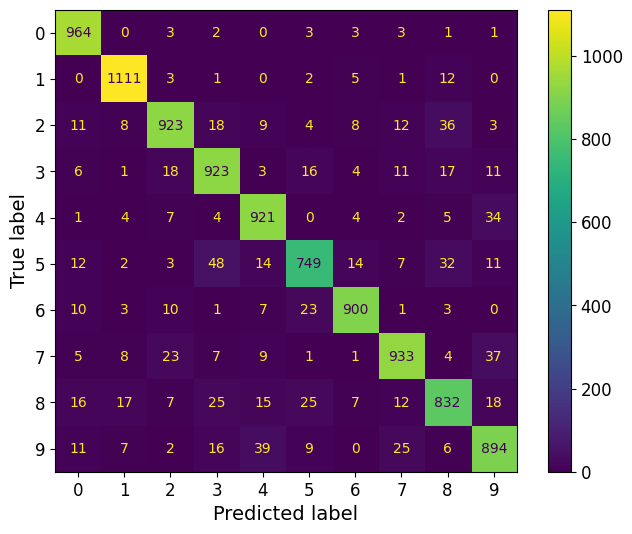

In [88]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat,values_format='.5g' )
plt.show()

In [89]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



## Multi-class LogisticRegression using solvers

In [90]:
pipe_logit_ovr = make_pipeline(
    MinMaxScaler(), LogisticRegression(random_state=1729, solver="lbfgs", C=np.infty)
)

pipe_logit_ovr.fit(x_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

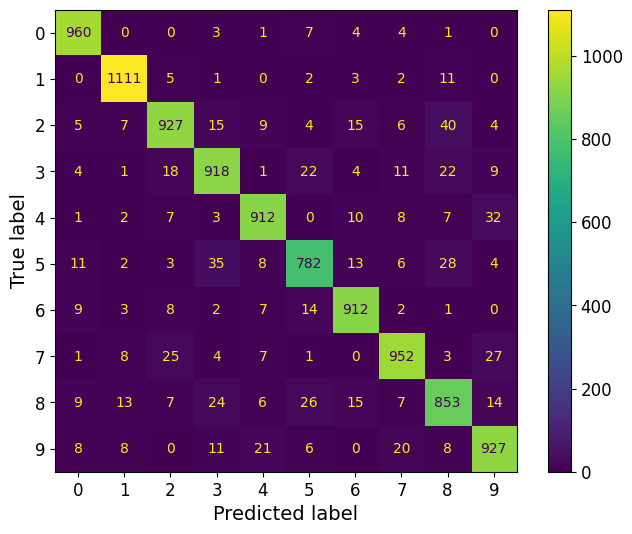

In [91]:
y_hat = pipe_logit_ovr.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format=".5g")

plt.show()

In [92]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



## Visualize the weight values

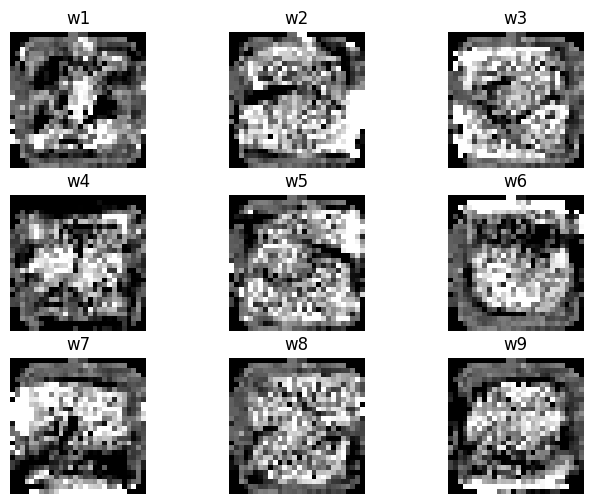

In [94]:
W = pipe_logit_ovr[1].coef_
# normalize
W = MinMaxScaler() .fit_transform(W)
fig,ax = plt.subplots(3,3)
index = 1
for i in range(3):
    for j in range(3):
        ax[i] [j].imshow(W[ index, : ].reshape (28, 28) , cmap='gray')
        ax[i] [j].set_title('w{0}'.format (index) )
        ax[i] [j].set_axis_off()
        index += 1